In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean
from rlhfutils.rl_utils import get_synth_rewards

from tqdm import tqdm
import numpy as np

from datasets import Dataset, concatenate_datasets
import seaborn as sns

/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-03-25 07:51:32,750] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/trl/trainer/ppo_config.py:142: UserWarning: The `optimize_cuda_cache` argument will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [2]:
%load_ext autoreload
%autoreload 2

In [32]:
def loadf(fname): 
    tlog = pd.read_json(fname, orient='records', lines=True)
    tmp = tlog
    if 'golds' not in tmp.keys():
        tmp['golds'] = tmp['rewards']
    tmp = tmp.dropna(subset='golds')
    print(len(tmp))
    return tmp

# Function to create a scatter plot comparing a baseline method to a new method
def ratio_scatter(baseline, method, steps=2000, baseratio=1, methodratio=1, fname="output.pdf", setname="Experiment Results", methmax=True, labels=['OPO with Gold', "ARMoUR"]):
    # Set the aesthetic style of the plots to be more appealing and professional
    sns.set(style="whitegrid")

    # Normalize the x-axis values for each list
    baseline_x = np.linspace(0, steps, len(baseline)) * baseratio
    method_x = np.linspace(0, steps, len(method)) * methodratio

    if methmax:
        # Determine the max x-axis value based on the smaller dataset
        max_x_value = min(max(baseline_x), max(method_x))
        
        # Filter out the points that exceed the max_x_value for both datasets
        baseline_x, baseline = zip(*[(x, y) for x, y in zip(baseline_x, baseline) if x <= max_x_value])
        method_x, method = zip(*[(x, y) for x, y in zip(method_x, method) if x <= max_x_value])

    # Creating a figure and axis object
    plt.figure(figsize=(10, 6))

    # Plot each dataset using seaborn for better aesthetics
    if baseratio>=0:
        sns.scatterplot(x=baseline_x, y=baseline, color='blue', label=labels[0], s=25)
    sns.scatterplot(x=method_x, y=method, color='red', label=labels[1], s=25, edgecolor='red')

    # Adding enhancements for clarity and aesthetics
    plt.title(setname, fontsize=26, fontweight='bold')
    plt.xlabel('Gold Preference Data Used', fontsize=20)
    plt.ylabel('Average Gold Reward' if baseratio>=0 else "RM Accuracy on Samples", fontsize=20)
    plt.legend(prop={'size': 16})
    plt.tight_layout()

    # Saving the figure in high-quality
    plt.savefig(fname, format="pdf", bbox_inches="tight")

    plt.show()

def makengs(ntmp, sind=0): 
    rat = 0
    ngs = []
    accs = []
    sind = 0
    print(ntmp.loc[0])
    for ind, row in ntmp.iloc[sind:].iterrows():
        # row['golds'] = get_synth_rewards(row['texts'], 'bagofwords')
        if len(row['golds'])==0:
            continue
        ngs.append(row['golds'])
        if row['golds'][0]==row['golds'][1]:
                continue
        if ((row['rewards'][0]>row['rewards'][1])!=(row['golds'][0]>row['golds'][1])):
            rat+=1
            accs.append(0)
        else:
            accs.append(1)
    #tmp['golds'] = ngs
    print(rat/len(ngs))
    return ngs, accs

def accscatter(acclist, interv=200): 
    vals = []
    for j in range(0, len(acclist), interv):
        vals.append(mean(acclist[j:j+interv]))
    return plt.scatter(range(len(vals)), vals)
    

In [5]:
# baselines for all our things
basefs = {
    'nouns':"../outputs/results/rollouts/nouns/ppo_goldb8.jsonl",
    'bagofwords':"../outputs/results/rollouts/bagofwords/ppo_goldb8_dpobase_v2.jsonl",
    'math':"../outputs/results/rollouts/math/ppo_goldb8easy4fix.jsonl",
    'cdist':"../outputs/results/rollouts/contrastivedistill/ppo_goldb8.jsonl",
    'ultra':"../outputs/results/rollouts/ultra/ppo_ultragolddpoplusfinal2.jsonl"
}

# using only fixed distribution data, in ARMOUR fashion
basefs = {
    'nouns':"../outputs/results/dynarmlogs//nouns/smalldpo_confnoun_newalgo_2_5_seed2_dpoapi.jsonl",
    'bagofwords':"../outputs/results/dynarmlogs/bagofwords/bowtiny_dpo_conf_newalgo_5testnewseed2_dpoapi.jsonl",
    'cdist':"../outputs/results/dynarmlogs/contrastivedistill/smalldpo_rand_cdist_10_5_activefixseed2.jsonl",
}


# using only fixed distribution data, in ARMOUR fashion
basefs = {
    'nouns':"../outputs/results/dynarmlogs//nouns/tiny_rm_confnoun_newalgo_2_5_seed2_oldupdates.jsonl",
    'bagofwords':"../outputs/results/dynarmlogs/bagofwords/bowtiny_rm_conf_newalgo_5testnewseed2_oldupdates.jsonl",
    'cdist':"../outputs/results/dynarmlogs/contrastivedistill/tiny_rm_rand_cdist_10_5_activefixseed2_oldupdates.jsonl",
}

# using only fixed distribution data, in ARMOUR fashion
basefs = {
    'nouns':"../outputs/results/rollouts/nouns/ppo_confnoun_goldb8_4ups.jsonl",
    'bagofwords':"../outputs/results/rollouts//bagofwords/ppo_conf_newalgo_goldb8_1ups.jsonl",
    'cdist':"../outputs/results/rollouts/contrastivedistill/ppo_contdistb8_moreupdates_4ups.jsonl",
}

# more spaced out
basefs = {
    'nouns':"../outputs/results/dynarmlogs//nouns/tiny_rm_randnoun_newalgo_100small_200testv3.jsonl",
    'bagofwords':"../outputs/results/dynarmlogs//bagofwords/bowtiny_rm_conf_newalgo_100small_500test.jsonl",
    'cdist':"../outputs/results/dynarmlogs/contrastivedistill/smalldpo_rand_cdist_10_5_activefixseed2.jsonl",
}

# initrm baselines
basefs = {
    'nouns':"../outputs/results/rollouts/nouns/ppo_noun_initrmbaseline.jsonl",
    'bagofwords':"../outputs/results/rollouts//bagofwords/ppo_bow_initrmbaseline.jsonl",
    'cdist':"../outputs/results/rollouts//contrastivedistill/ppo_cdist_initrmbaseline.jsonl",
}

basefs = {
    'nouns':"../outputs/results/rollouts/nouns/ppo_confnoun_newalgo_2_5_log.jsonl",
    'bagofwords':"../outputs/results/rollouts//bagofwords/ppo_conf_newalgo_5testlogrun.jsonl",
    'cdist':"../outputs/results/rollouts//contrastivedistill/ppo_rand_cdist_10_5_logrun.jsonl",
}

# basefs = {
#     'nouns':"../outputs/results/rollouts/nouns/ppo_confnoun_goldb8_selfreward.jsonl",
#     'bagofwords':"../outputs/results/rollouts/bagofwords/ppo_confbow_goldb8_selfreward.jsonl",
#     'cdist':"../outputs/results/rollouts/contrastivedistill/ppo_confcdist_goldb8_selfreward.jsonl",
# }

# methods that do the best in each thing
bestmethds = {
    'nouns':["../outputs/results/dynarmlogs/nouns/tiny_rm_confnoun_newalgo_2small_5testv3new.jsonl",
             "../outputs/results/dynarmlogs/nouns/tiny_rm_confnoun_newalgo_2_5_seed2.jsonl",
             "../outputs/results/dynarmlogs/nouns/tiny_rm_confnoun_newalgo_2_5_seed3.jsonl",
            ],
    'bagofwords':["../outputs/results/dynarmlogs/bagofwords/bowtiny_rm_conf_newalgo_5testnew.jsonl",
                  "../outputs/results/dynarmlogs/bagofwords/bowtiny_rm_conf_newalgo_5testnewseed2.jsonl",
                  "../outputs/results/dynarmlogs/bagofwords/bowtiny_rm_conf_newalgo_5testnewseed3.jsonl",
                 ],
    'math':"../outputs/results/dynarmlogs/math/tiny_rm_rand8repeasy4_1v2fix.jsonl",
    'cdist':["../outputs/results/dynarmlogs/contrastivedistill/tiny_rm_rand_cdist_10_5_activefixseed3.jsonl",
             "../outputs/results/dynarmlogs/contrastivedistill/tiny_rm_rand_cdist_10_5_activefixseed2.jsonl",
             "../outputs/results/dynarmlogs/contrastivedistill/tiny_rm_rand_cdist_10_5_activefix.jsonl"
            ],
    'ultra':"../outputs/results/dynarmlogs/ultra/tiny_rm_conf_active_newalgoultra.jsonl"
}
# seeds
# bestmethds = {
#     'nouns':"../outputs/results/dynarmlogs/nouns/tiny_rm_confnoun_newalgo_2_5_seed3.jsonl",
#     'bagofwords':"../outputs/results/dynarmlogs/bagofwords/bowtiny_rm_conf_newalgo_5testnewseed3.jsonl",
#     'math':"../outputs/results/dynarmlogs/math/tiny_rm_easy4_32_2_try_seed2.jsonl",
#     'cdist':"../outputs/results/dynarmlogs/contrastivedistill/tiny_rm_rand_cdist_10_5_activefixseed3.jsonl",
#     'ultra':"../outputs/results/dynarmlogs/ultra/tiny_rm_conf_active_newalgoultra.jsonl"
# }

mratios = {'bagofwords':2, 'nouns':0.4, 'math':2, 'cdist':1, 'ultra':8}
dset = "bagofwords"
tmpbase = loadf(basefs[dset])
basengs, baseaccs = makengs(tmpbase)
print("loaded base")
allmethngs = []
allmethaccs = []
# have a  list of stuff, TODO there's a better way to check this
if len(bestmethds[dset])<5:
    for d in bestmethds[dset]:
        tmpmethod = loadf(d)
        methngs, methaccs = makengs(tmpmethod)
        allmethngs.append(methngs)
        allmethaccs.append(methaccs)
        
print("loaded method")

# tlog = pd.read_json("../../active-rlhf/outputs/results/rollouts/math/ppo_goldb8easy4fix.jsonl", orient='records', lines=True, nrows=64000)
# tlog = pd.read_json("../../outputs/bagofwords/dynarmlogs/expbow50_updatereprod_fix.jsonl", orient='records', lines=True)
# tlog = pd.read_json("../../activereprod/active-rlhf/outputs/results/dynarmlogs/math/u/prasanns/research/active-rlhf/outputs/models/math/tiny_rm_rand_subsamp_onlymathreprod3.jsonl", orient='records', lines=True)
# tlog = pd.read_json("../outputs/results/dynarmlogs/.jsonl", orient='records', lines=True)

4000
inputs      [How does the use of the plectrum, or mizrab, ...
outputs     [ Thank for taking the time to comment on your...
rewards     [4.34375, 4.125, 4.9375, 5.0, 3.984375, 5.2812...
keepinds    [0, 3, 5, 7, 9, 11, 12, 15, 17, 18, 21, 22, 24...
selfscos    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
step                                                        0
golds       [4.34375, 4.125, 4.9375, 5.0, 3.984375, 5.2812...
Name: 0, dtype: object
0.0
loaded base
64000
texts      [Question: Write a persuasive business letter ...
rewards                                    [5.6875, 5.65625]
golds                                             [3.0, 4.0]
call                                                  [1, 1]
Name: 0, dtype: object
0.1731875
64000
texts      [Question: Detail a day in the life of a real ...
rewards                                      [5.625, 4.9375]
golds                                             [6.0, 5.0]
call                                              

In [48]:
baseratio = 8

In [24]:
basengs, baseaccs = makengs(newtest)
methngs, methaccs = makengs(tmpdynarmlogs)

texts      [Question: The population was 1,362 at the 200...
rewards                                           [0.0, 0.0]
golds                                      [-0.375, -0.0625]
call                                                  [1, 1]
Name: 0, dtype: object
0.23846875
texts      [Question: The population was 1,362 at the 200...
rewards                       [-0.1279296875, -0.1240234375]
golds                                      [-0.375, -0.0625]
call                                                  [1, 1]
Name: 0, dtype: object
0.234921875


In [25]:
allmethngs = []

In [29]:
# get sliding window means over some input list (smoothened)
def intervmean(vals, interv=50, window=400):
    return [mean(vals[i:i+window]) for i in range(0, len(vals)-window, interv)]    

def combineall(vallists, inte=50, wind=400):
    newls = [[mean(m) for m in blist] for blist in vallists]
    finl = []
    for i in range(len(newls[0])):
        finl.append(mean([newls[j][i] for j in range(len(newls))]))
    return finl

basemeans = intervmean([mean(m) for m in basengs], 5, 25)
if len(allmethngs)>0:
    methmeans = intervmean(combineall(allmethngs), 25 , 50)
else:
    methmeans = intervmean([mean(m) for m in methngs], 25 , 50)
baseacms = intervmean(baseaccs, 25, 250)
methacms = intervmean(methaccs, 25 , 250)

In [30]:
mean(methmeans[-20:-10])

0.2272265625

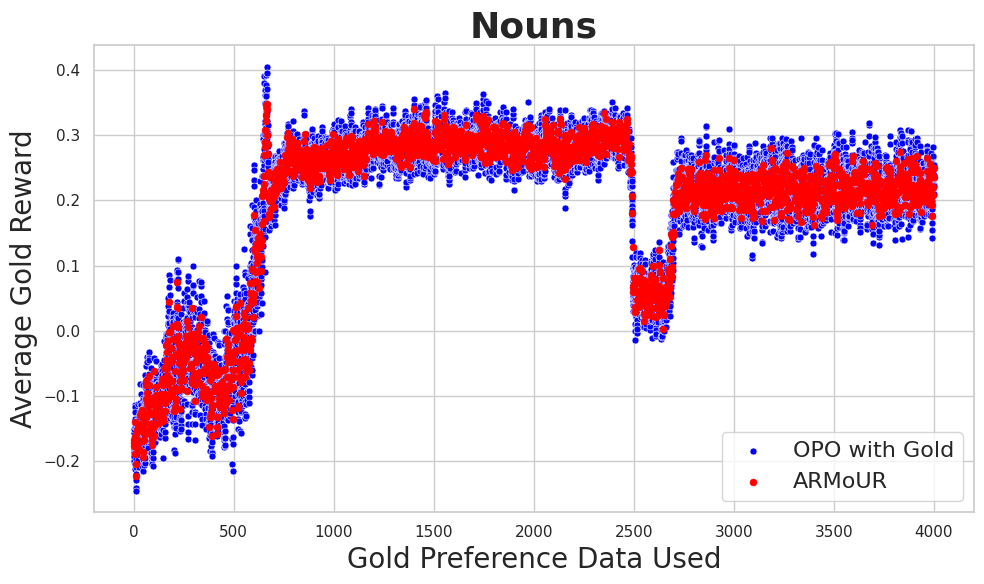

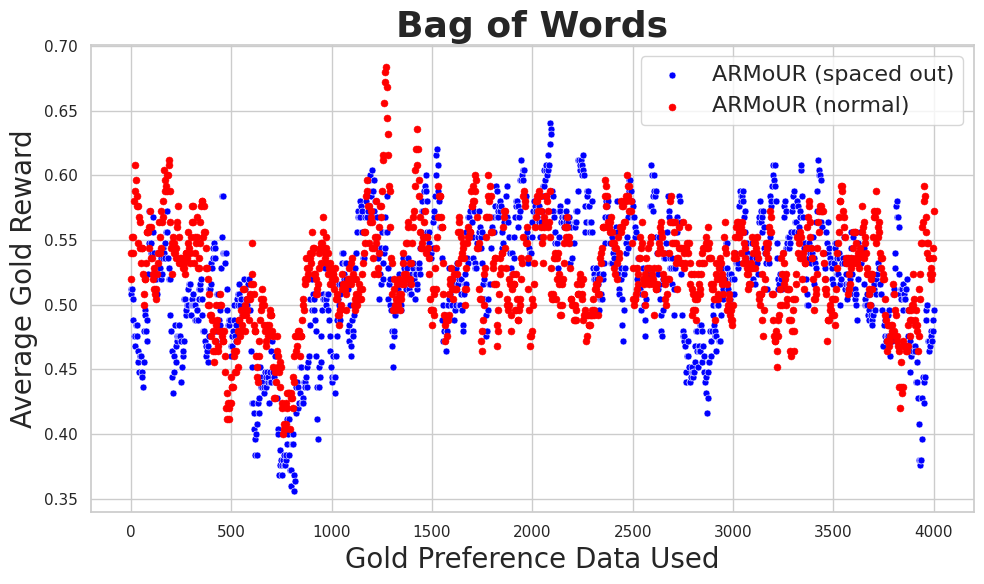

In [33]:
fig = ratio_scatter(basemeans, methmeans, 2000, mratios[dset], mratios[dset], "efficientplots/"+dset+".pdf", "Nouns")
# fig = ratio_scatter(basemeans, basemeans, 2000, baseratio, baseratio, "efficientplots/tmp"+".pdf", "tmp")

fig = ratio_scatter(baseacms, methacms, 2000, mratios[dset], mratios[dset], "efficientplots/acc"+dset+".pdf", "Bag of Words", methmax=False, labels=['ARMoUR (spaced out)', 'ARMoUR (normal)'])

In [30]:
def splitter(inp):
    # qa style
    if ("Question:" in inp) and "Answer:" in inp: 
        instruction, response = inp.split("\n\nAnswer: ")
        instruction = instruction[len("Question: "):]
    # alpacafarm style
    if "### Instruction:" in inp:
        instruction_match = re.search(r'### Instruction:\n(.*?)(### Response:|\Z)', inp, re.DOTALL)
        instruction = instruction_match.group(1).strip() if instruction_match else inp
        # Extract Response
        response_match = re.search(r'### Response:.*?(.*?)(### |\Z)', inp, re.DOTALL)
        response = response_match.group(1).strip() if response_match else ""
    # tulu style
    if "<user>" in inp: 
        q = inp[len("<user>\n"):]
        instruction, response = q.split("\n<assistant>\n")
    
    return instruction, response
# given a starting index (default 0), and some other thing, return the
# better and worse index in that order
def indcomp(rws, sind=0, eind=-1): 
    # extra functionalty
    if eind>=0: 
        return (sind, eind) if rws[sind]>rws[eind] else (eind, sind)
    if rws[0]>rws[1]:
        return 0+sind, 1+sind
    return 1+sind, 0+sind
    
# given a dataframe with a "golds" column, make rollouts into preference data (assume that pairs go together as rollouts)
def dynarm_to_prefs(indf):
    prefdata = []
    for ind, row in indf.iterrows():
        inp = splitter(row['texts'][0])[0]
        resps = [splitter(row['texts'][i])[1] for i in range(2)]
        indj, indk = indcomp(row['golds'], 0)
        tmp = {
            'question': inp,
            'response_j': resps[indj],
            'response_k': resps[indk],
            'score_j': row['golds'][indj], 
            'score_k': row['golds'][indk],
            'magnitude': row['golds'][indj] - row['golds'][indk]
        }
        prefdata.append(tmp)
            
    return Dataset.from_list(prefdata)
    
# get a training set or eval set from some input
def interv_setup(indata, amt=5, start=0, end=(1/16)):
    # Create a mask to identify rows where the two numbers in each list are identical
    mask = indata['golds'].apply(lambda x: x[0] != x[1])
    
    # Filter out rows where numbers are identical
    filtered_df = indata[mask]
    
    # based on old index, not the new thing
    subset = filtered_df.loc[int(len(indata)*start):int(len(indata)*end)]
    return subset.sample(amt)


In [ ]:
for i in range(0, 5):
    t = interv_setup(tmpmethod, 5)
    p = dynarm_to_prefs(t)
    print(p[0])
    #p.save_to_disk("../outputs/data/"+dset+"/5set"+str(i))

for i in range(0, 5):
    t = interv_setup(tmpmethod, 50)
    p = dynarm_to_prefs(t)
    print(p[0])
    #p.save_to_disk("../outputs/data/"+dset+"/50set"+str(i))

In [109]:
t = interv_setup(tmpmethod, 200, (1/16), (2/16))
p = dynarm_to_prefs(t)
print(p[0])
p.save_to_disk("../outputs/data/"+dset+"/latereval")

t = interv_setup(tmpmethod, 200, (0), (1/16))
p = dynarm_to_prefs(t)
print(p[0])
p.save_to_disk("../outputs/data/"+dset+"/earlyeval")

{'question': 'Write a formal letter of request to a supplier requesting them to arrange a product demonstration at your workplace, highlighting the specific product features that you want to be demonstrated and providing the suggested dates and times for the demonstration.', 'response_j': "\n' New / New / American | Restaurant | LampBot | Catering | Biotechnology | Grade Code this class are: Crown Coffee / Ace Okong / Olive Oil /: Lemonhead /: Keurjuic /: Lucent", 'response_k': '\n\n• Architect, Requirements; Client ("Automation software), Software Developer (AMS), ILM, PrettyBox, Applied Water Optics (NASNAS, JPEGO, etc.), (hardware, electronics, telecom, entertainment', 'score_j': 27.0, 'score_k': 20.0, 'magnitude': 7.0}


{'question': 'Which surfacing materials are suitable for the Play Mound and Tunnel and how do they enable year-round use?: This durable Play Mound and Tunnel offers hours of fun from the crawl through tunnel to the large play mound and lookout points. It supports the understanding of positional language, as children can go under, over, around, be above, below and look through the windows. Its also great for inspiring imaginative and creative play.\nCombined with your choice of surfacing, ranging from synthetic grass, wet pour safety surfacing or rubber bark, it provides all year round use. Great as an addition to any adventure play space or as an imaginative transition between outside zones.', 'response_j': '\nWhile the Play Mound and Tunnel is a linear, non-stone-like structure, which supports the play mound and the tuning wheel, it is excellent for play structures such as fence, pegback, and stair slides. Just as you', 'response_k': '\nThe Play Mound and Tunnel all lend a splash of h

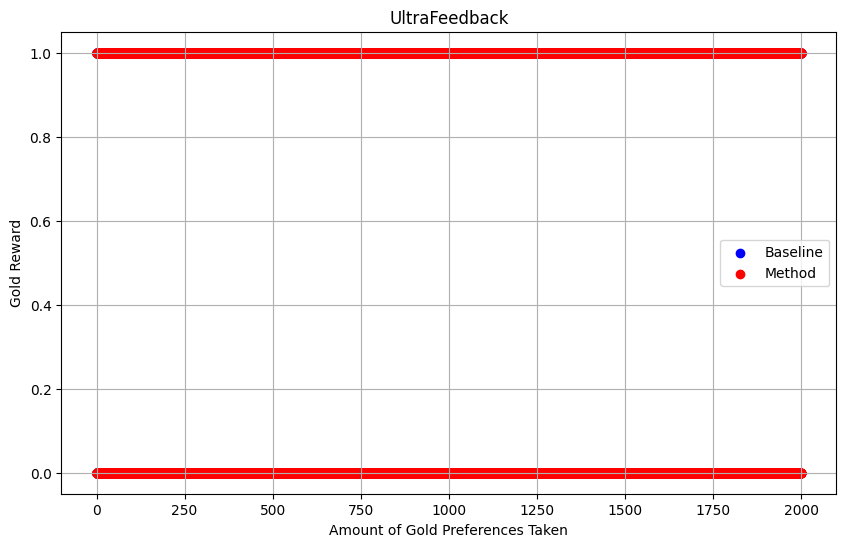

In [104]:
fig = ratio_scatter(baseaccs, methaccs, 2000, mratios[dset], mratios[dset], "efficientplots/"+dset+".pdf", "UltraFeedback")

In [6]:
tmpb = loadf("../outputs/results/rollouts/bagofwords/ppo_conf_newalgo_5testlogrun.jsonl")
tmpdynarmlogs = loadf("../outputs/results/dynarmlogs/bagofwords/bowtiny_rm_conf_newalgo_5testlogrun.jsonl")

4000


In [22]:
tmpb = loadf("../outputs/results/rollouts/contrastivedistill/ppo_rand_cdist_10_5_logrun.jsonl")
tmpdynarmlogs = loadf("../outputs/results/dynarmlogs/contrastivedistill/tiny_rm_rand_cdist_10_5_logrun.jsonl")

4000
64000


In [23]:
def newpairdf(tmpdf, rws, fdim=2):
    newdf = tmpdf.copy()
    tot = []
    for r in rws: 
        tot.extend(r)
    newv = []
    for i in range(0, len(tot), fdim):
        newv.append(tot[i:i+fdim])
    mval = min(len(newv), len(newdf))
    print(mval)
    print(len(newdf))
    newdf['rewards'][:min(len(newv), len(newdf))] = newv[:min(len(newv), len(newdf))]
    
    return newdf

newtest = newpairdf(tmpdynarmlogs, tmpb['selfscos'])

64000
64000


In [10]:
len(tmpb['selfscos'][0])

32

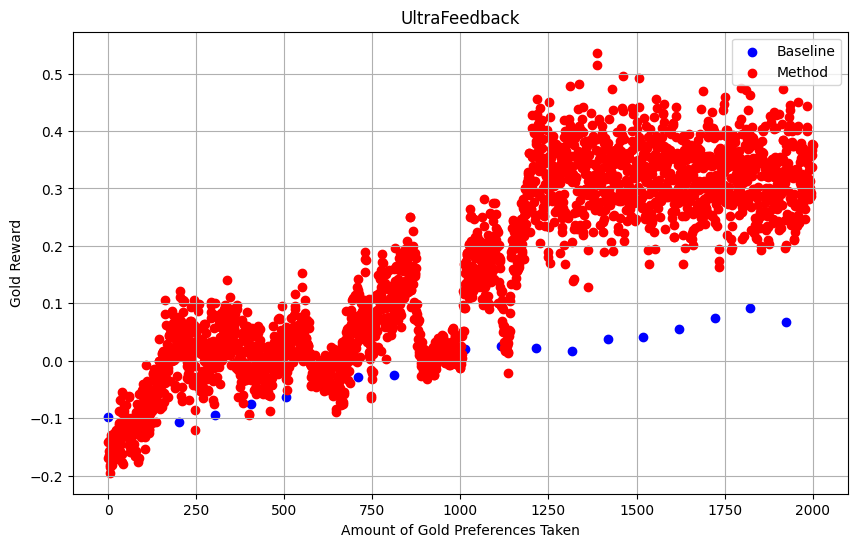

In [19]:
fig = ratio_scatter(basemeans, methmeans, 2000, baseratio, mratios[dset], "efficientplots/"+dset+".pdf", "UltraFeedback")

In [36]:
ngs, accs = makengs(tmp)

0.049515625


In [40]:
meanngs = list([mean(n) for n in ngs])

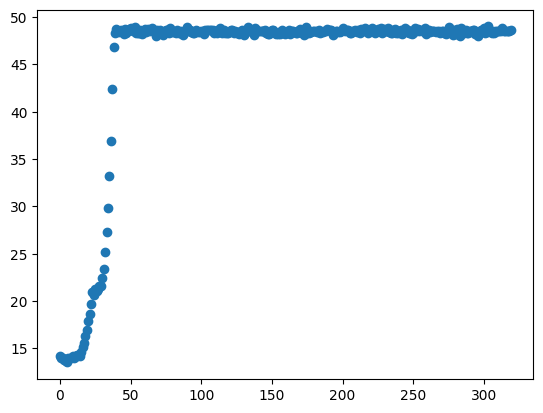

In [42]:
accscatter(meanngs)

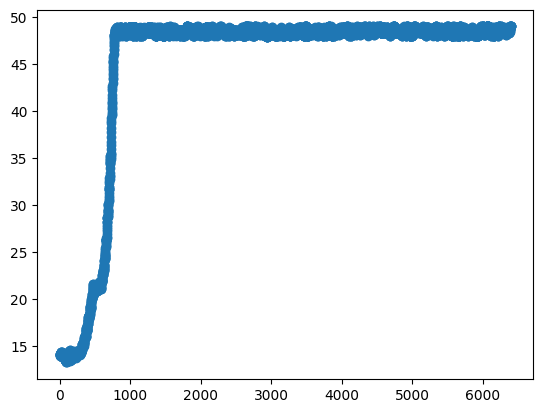

In [15]:
means = [mean(m) for m in ngs]
# means = [mean(m) for m in tmp['rewards']]

interv = 10
mbins = [mean(means[i:i+100]) for i in range(0, len(means), interv)]
plt.scatter(range(len(mbins)), mbins)

In [55]:
print(max(mbins))
print(mean(mbins[-100:]))

49.0
48.5851


In [194]:
tmp.iloc[1000:1010]

,texts,rewards,golds,call
1000,[Question: (((8 * 6) * 2) + 9) = \n\nAnswer: ...,"[-0.23632812500000003, -0.33984375]","[2.619047619047619, 2.611111111111111]","[63, 63]"
1001,[Question: (((2 * 9) * 4) - 2) = \n\nAnswer: ...,"[-0.2353515625, -0.2412109375]","[3.174603174603174, 3.611111111111111]","[63, 63]"
1002,[Question: (((7 * 8) - 4) - 8) = \n\nAnswer: ...,"[-0.208984375, -0.2314453125]","[2.444444444444444, 2.0]","[63, 63]"
1003,[Question: (((4 * 9) - (2 - 7)) - 2) = \n\nAns...,"[0.125, 0.12304687500000001]","[2.70021645021645, 1.7568779904306222]","[63, 63]"
1004,[Question: (((3 * 5) - 1) + 8) = \n\nAnswer: ...,"[-0.2470703125, -0.27734375]","[3.055555555555556, 2.166666666666667]","[63, 63]"
1005,[Question: (((9 * 3) * 5) + (4 * 3)) = \n\nAns...,"[-0.255859375, -0.259765625]","[3.178436147186147, 2.76176948051948]","[63, 63]"
1006,[Question: (((8 * 2) * 2) - 7) = \n\nAnswer: r...,"[-0.039306640625, -0.279296875]","[2.111111111111111, 2.444444444444444]","[63, 63]"
1007,[Question: (((1 * 4) * 1) * 4) = \n\nAnswer: ...,"[-0.1142578125, -0.2734375]","[4.166666666666667, 3.092592592592593]","[63, 63]"
1008,[Question: (((1 * 3) + 6) - 2) = \n\nAnswer: ...,"[-0.373046875, -0.251953125]","[2.777777777777777, 5.0]","[64, 64]"
1009,[Question: (((4 - 2) - 9) + (2 + 9)) = \n\nAns...,"[0.0137939453125, -0.23828125]","[2.285714285714286, 2.957417582417582]","[64, 64]"


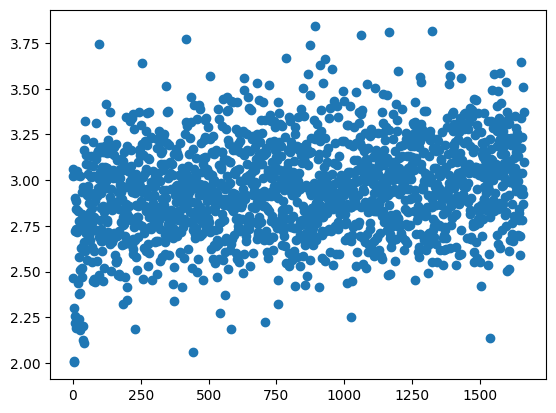

In [50]:
means = [mean(m) for m in tmp['golds']]
plt.scatter(range(len(means)), means)